In [20]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

### Load data

In [21]:
df = pd.read_csv("../data/clean/main_df.csv")

In [22]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})

def process_categorical(df, col):
    """
    Processes a column of *df* as categorical
    """

    def mapping(df, col):

        new_df = df.copy()

        values = new_df[col].unique()
        mapping = {value: i for i, value in enumerate(values)}
        new_df[col] = new_df[col].map(mapping)

        return new_df

    def one_hot(df, col):
        ext_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        ext_df.drop([col], axis=1, inplace=True)
        
        return ext_df

    return mapping(df, col)

df.drop(["tmID"], axis=1, inplace=True)
df.fillna(-1, inplace=True)
df = process_categorical(df, "confID")
# df = process_categorical(df, "tmID")
# map_strings_to_int(df, "playerID")
# map_strings_to_int(df, "coachID")
# map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

# print(df['tmID'].to_frame())

### Turn string values into numerical ones

### Training and evaluation function

In [23]:
from dataclasses import dataclass

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = {}

def classification(model, df, min_year, max_year, param_list):

    def cv(df, min_year, max_year):
        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop("playoff", axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop("playoff", axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable


    def score(model, df, min_year, max_year):
        results = []
        
        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop("playoff", axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop("playoff", axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable
        
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            results.append(accuracy_score(y_test, y_pred))

        return sum(result * (i + 1) for result, i in enumerate(results)) / sum(range(len(results) + 1))

    def param_tuning(model, df, min_year, max_year, param_list):
        grid = HalvingRandomSearchCV(model, param_distributions=param_list, cv=5, min_resources='smallest', n_jobs=16, random_state=42, scoring=lambda model, X, y: score(model, df, min_year, max_year))
        grid.fit(df.drop("playoff", axis=1), df["playoff"])
        
        return grid.best_estimator_
    
    def test_model(model, df, params):
        pass

    model = param_tuning(model, df, min_year, max_year, param_list)

    for i in range(min_year, max_year + 1):
        df_train = df[(df['year'] < i) & (df['year'] > 1)]
        df_test = df[df['year'] == i]

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=roc_auc_score(y_test, y_pred),
        )

        if (str(model) not in results):
            results[str(model)] = []
        results[str(model)].append(result)
    
    return model

### Define values for min_year and max_year

In [24]:
min_year = 3
max_year = df['year'].max() - 1

### Decision Tree


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.75      0.63         8
         1.0       0.60      0.38      0.46         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[6 2]
 [5 3]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.25      0.17      0.20         6
         1.0       0.50      0.62      0.56         8

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14


year = 4, Confusion Matrix:
 [[1 5]
 [3 5]]

year = 4, AUC:

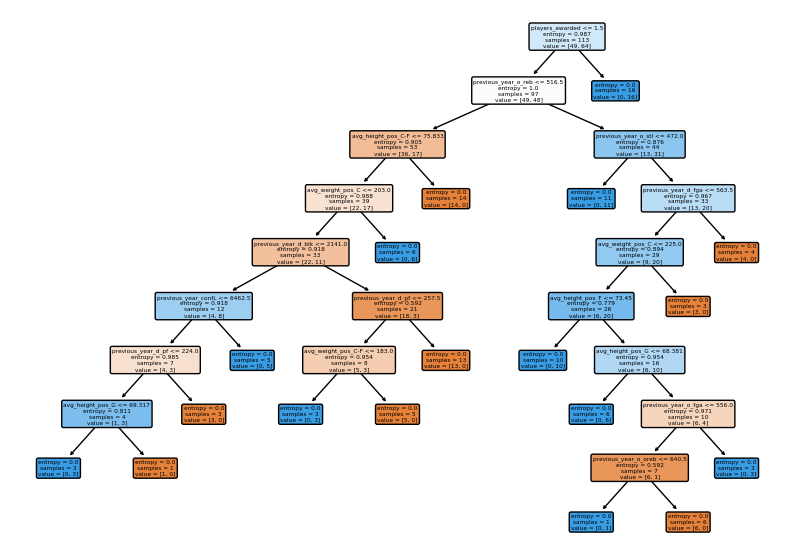

In [25]:
model = DecisionTreeClassifier(random_state=42)
model = classification(model, df, min_year, max_year, param_list={
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 20),
})

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [26]:
model = SVC(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': range(1, 10),
    'gamma': ['scale', 'auto'],
    'C': range(1, 10),
})


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.50      0.62         8
         1.0       0.64      0.88      0.74         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16


year = 3, Confusion Matrix:
 [[4 4]
 [1 7]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.50      0.55         6
         1.0       0.67      0.75      0.71         8

    accuracy                           0.64        14
   macro avg       0.63      0.62      0.63        14
weighted avg       0.64      0.64      0.64        14


year = 4, Confusion Matrix:
 [[3 3]
 [2 6]]

year = 4, AUC:

SVC(C=7, degree=1, kernel='sigmoid', random_state=42)

### Logistic Regression

In [27]:
model = LogisticRegression(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': range(1, 10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000],
})

/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packa


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.50      0.62         8
         1.0       0.64      0.88      0.74         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16


year = 3, Confusion Matrix:
 [[4 4]
 [1 7]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.83      0.71         6
         1.0       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14


year = 4, Confusion Matrix:
 [[5 1]
 [3 5]]

year = 4, AUC:

/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio param

LogisticRegression(C=4, max_iter=1000, penalty='none', random_state=42,
                   solver='sag')

### Random Forest

In [28]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year, {
    'n_estimators': range(1, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
})


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.62      0.59         8
         1.0       0.57      0.50      0.53         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16


year = 3, Confusion Matrix:
 [[5 3]
 [4 4]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.83      0.67         6
         1.0       0.80      0.50      0.62         8

    accuracy                           0.64        14
   macro avg       0.68      0.67      0.64        14
weighted avg       0.70      0.64      0.64        14


year = 4, Confusion Matrix:
 [[5 1]
 [4 4]]

year = 4, AUC:

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=5,
                       random_state=42)

### Gradient Boosting Classifier

In [29]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year, {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': range(1, 10),
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': range(1, 10),
})

/home/toino/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name '


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.75      0.63         8
         1.0       0.60      0.38      0.46         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[6 2]
 [5 3]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.33      0.17      0.22         6
         1.0       0.55      0.75      0.63         8

    accuracy                           0.50        14
   macro avg       0.44      0.46      0.43        14
weighted avg       0.45      0.50      0.46        14


year = 4, Confusion Matrix:
 [[1 5]
 [2 6]]

year = 4, AUC:

GradientBoostingClassifier(criterion='squared_error', learning_rate=1,
                           loss='deviance', max_depth=6, n_estimators=6)

### K Neighbors

In [30]:
model = KNeighborsClassifier()
classification(model, df, min_year, max_year, param_list={
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(1, 10),
    'p': [1, 2],
})


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         8
         1.0       0.50      0.50      0.50         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.50        16
weighted avg       0.50      0.50      0.50        16


year = 3, Confusion Matrix:
 [[4 4]
 [4 4]]

year = 3, AUC:  0.5

year = 3, Accuracy:  0.5

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.50      0.46         6
         1.0       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14


year = 4, Confusion Matrix:
 [[3 3]
 [4 4]]

year = 4, AUC:  0.5


KNeighborsClassifier(algorithm='brute', leaf_size=5, n_neighbors=3)

### Neural networks

In [31]:
model = MLPClassifier(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'hidden_layer_sizes': [(50, 25)],  
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'solver': ['adam'],
    'max_iter': [1000],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
})



Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16


year = 3, Confusion Matrix:
 [[3 5]
 [0 8]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.17      0.25         6
         1.0       0.58      0.88      0.70         8

    accuracy                           0.57        14
   macro avg       0.54      0.52      0.48        14
weighted avg       0.55      0.57      0.51        14


year = 4, Confusion Matrix:
 [[1 5]
 [1 7]]

year = 4, AUC:

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25),
              learning_rate='invscaling', max_iter=1000, random_state=42)

# Results

In [32]:
from pprint import pprint

# Extracting accuracy for the last year for each model
previous_year_accuracies = {model: results[model][-1] for model in results}

# Sorting the results by accuracy in descending order
sorted_results = dict(sorted(previous_year_accuracies.items(), key=lambda item: item[1].accuracy, reverse=True))

# Printing the results
print("Train/test results for the last year of data:\n")
for model, result in sorted_results.items():
    print(f"{model} -- Accuracy: {result.accuracy:.4f}, AUC: {result.auc:.4f}")

for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

Train/test results for the last year of data:

KNeighborsClassifier(algorithm='brute', leaf_size=5, n_neighbors=3) -- Accuracy: 0.6923, AUC: 0.6750
SVC(C=7, degree=1, kernel='sigmoid', random_state=42) -- Accuracy: 0.6154, AUC: 0.5000
MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25),
              learning_rate='invscaling', max_iter=1000, random_state=42) -- Accuracy: 0.6154, AUC: 0.5000
DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42) -- Accuracy: 0.5385, AUC: 0.5125
RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=5,
                       random_state=42) -- Accuracy: 0.5385, AUC: 0.4750
LogisticRegression(C=4, max_iter=1000, penalty='none', random_state=42,
                   solver='sag') -- Accuracy: 0.4615, AUC: 0.4125
GradientBoostingClassifier(criterion='squared_error', learning_rate=1,
                           loss='deviance', max_depth=6, n_estimators=6) -- Accuracy: 0.4615, AUC: 0.4125
